In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import itertools

# Downloading Data

In [8]:
# Load Data

full = pd.read_csv('deer.csv',sep='\t')
full.head()

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,...,recordnumber,identifiedby,rights,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,1088894118,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/849723,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Alces,Alces americanus,...,NaN,NaN,© Charlie Hohn some rights reserved,Charlie Hohn,Charlie Hohn,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
1,1088900045,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1247846,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© dwest some rights reserved,dwest,dwest,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
2,1088904736,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1257570,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Odocoileus,Odocoileus virginianus,...,NaN,NaN,© byzantinenature some rights reserved,byzantinenature,byzantinenature,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
3,1088905648,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1259468,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© pdatema some rights reserved,pdatema,pdatema,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
4,1088920945,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1299029,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© BJ Stacey some rights reserved,BJ Stacey,BJ Stacey,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;TAXON_MATCH_HIGHERRANK;GEOD...


In [9]:
full.columns.values

array(['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'countrycode', 'locality', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'rights',
       'rightsholder', 'recordedby', 'typestatus', 'establishmentmeans',
       'lastinterpreted', 'mediatype', 'issue'], dtype=object)

In [10]:
full[['locality','decimallatitude','decimallongitude','eventdate','day','month','year']].head(30)

,locality,decimallatitude,decimallongitude,eventdate,day,month,year
0,NaN,43.16769,-72.64119,2014-08-26T19:59Z,26,8,2014
1,NaN,38.12045,-121.93823,2015-02-19T17:50Z,19,2,2015
2,NaN,40.09893,-85.61851,2015-02-25T00:00Z,25,2,2015
3,NaN,45.18113,-84.34583,2015-02-25T19:10Z,25,2,2015
4,NaN,41.22412,-124.09071,2015-02-14T00:00Z,14,2,2015
5,NaN,44.24394,-72.78249,2015-03-23T00:00Z,23,3,2015
6,NaN,38.16600,-122.93700,2015-03-31T20:00Z,31,3,2015
7,"Anchorage, Anchorage International Airport",NaN,NaN,1961-02-18T00:00Z,18,2,1961
8,specific locality not recorded,NaN,NaN,1961-08-22T00:00Z,22,8,1961
9,4 mi S of Anaktuvuk Pass,NaN,NaN,1962-10-08T00:00Z,8,10,1962


Notes: Data effected by number of yearas we include? maybe just include 1 year. this data doesn't include year in year column. some data can be downloaded by year i think

In [11]:
data = full[['decimallatitude','decimallongitude','year']]
data.head()

,decimallatitude,decimallongitude,year
0,43.16769,-72.64119,2014
1,38.12045,-121.93823,2015
2,40.09893,-85.61851,2015
3,45.18113,-84.34583,2015
4,41.22412,-124.09071,2015


In [12]:
data[data['year']==2015].values.shape

(1285, 3)

In [13]:
data2015 = data[data['year']==2015]
data2015 = data2015[['decimallatitude','decimallongitude']]
data2015.head()

,decimallatitude,decimallongitude
1,38.12045,-121.93823
2,40.09893,-85.61851
3,45.18113,-84.34583
4,41.22412,-124.09071
5,44.24394,-72.78249


# Data Exploration

In [14]:
data2015 = data2015.dropna()
data2015.shape

(1280, 2)

#### Grids (From EM code)

In [16]:
# Create the 10.0 x 10.0 lat-long grid squares
# Changing the size of the lat-long grid squares will have a large effect on the results
lats = np.arange(-90, 100, 5)
longs = np.arange(-180, 190, 5)

# Generate the grid
grids = list(itertools.product(lats, longs))

num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids

Using these lat-long settings, there are 2812 grid squares


In [17]:
# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

In [18]:
# returns grid_id index
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))

In [19]:
print 'lat ids: ', np.array(grid_ids)[:,0]
print 'long ids: ', np.array(grid_ids)[:,1]

lat ids:  [ 1  1  1 ..., 38 38 38]
long ids:  [ 1  2  3 ..., 72 73 74]


In [20]:
data2015.head()

,decimallatitude,decimallongitude
1,38.12045,-121.93823
2,40.09893,-85.61851
3,45.18113,-84.34583
4,41.22412,-124.09071
5,44.24394,-72.78249


In [21]:
data2015.iloc[0,0], data2015.iloc[0,1]

(38.120449999999998, -121.93823)

In [22]:
# create store for grid id indexes
grid_counts = np.zeros(len(grid_ids))

# Build grid counts
for i in range(0, len(data2015)):
    # get grid id index
    idx = get_grid_id_from_lat_long(data2015.iloc[i,0],data2015.iloc[i,1])
    
    # add to grid_counts
    grid_counts[idx] += 1

In [23]:
max(grid_counts)

242.0

In [24]:
N = len(grid_counts)

s = ''
for i in range(N):
    if grid_counts[i] == 0:
        s = s + '-'
    else:
        s = s + str(int(grid_counts[i])) + "'"
        
    if i % 73 == 0 and i != 0:
        print s + '|'
        s = ''

--------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
-------------------------------------------------------------------------|
------------------------

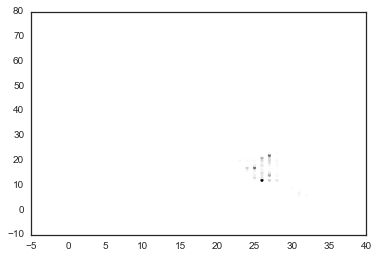

In [25]:
grid_ids = np.array(grid_ids)

def plot_grid(grid_counts):
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(grid_ids[:,0], grid_ids[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()
    
plot_grid(grid_counts)

In [ ]:
# Look at distribution (do we use Poisson?)
# What size do we use for the grid squares?